# Logistic regression (multiclass classification) with MNIST

We use now multiclass logistic regression to recognize the digit.

The first part of this notebook is the same as the one to prepare the data in the [previous notebook](03-binary_logistic_regression.ipynb). Look that for more details.

In [113]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [114]:
mnist_train = pd.read_csv('../datasets/mnist_train.csv')
mnist_test = pd.read_csv('../datasets/mnist_test.csv')

In [115]:
x_train_raw = torch.tensor(mnist_train.iloc[:, 1:].values, dtype=torch.float32)
x_test_raw = torch.tensor(mnist_test.iloc[:, 1:].values, dtype=torch.float32)

In [116]:
x_train = x_train_raw / 255
x_test = x_test_raw / 255

In [117]:
y_train_raw = torch.tensor(mnist_train.iloc[:, 0].values, dtype=torch.int64).view(-1, 1)
y_test_raw = torch.tensor(mnist_test.iloc[:, 0].values, dtype=torch.int64).view(-1, 1)

In [118]:
def one_hot_encode(y, num_classes):
  return torch.eye(num_classes)[y].view(y.shape[0], num_classes)

In [119]:
y_train = one_hot_encode(y_train_raw, num_classes=10)
y_test = one_hot_encode(y_test_raw, num_classes=10)

In [120]:
n_training_samples = x_train.shape[0]
n_test_samples = x_test.shape[0]
n_features = x_train.shape[1]
n_classes = y_train.shape[1]
n_classes, n_features, n_training_samples, n_test_samples

(10, 784, 60000, 10000)

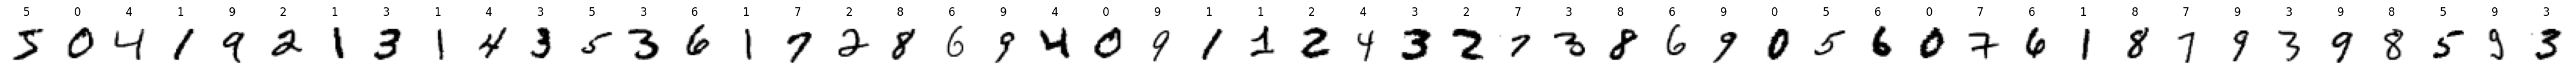

In [121]:
# sample plot of the data
n_sample = 50
fig = plt.figure(figsize=(n_sample, 1))
axs = []
for i in range(n_sample):
  axs.append(fig.add_subplot(1, n_sample, i+1))
  axs[i].imshow(x_train[i,:].view(28,28), cmap='gray_r')
  axs[i].set_title(f'{(y_train[i,:]==1).nonzero().item():.0f} ')
  axs[i].axis('off')

We recall how multiclass logistic regression works. We have some data $\{(x_i, y_i)\}_{i=0, \ldots, N-1}$ where $x_i \in \mathbb{R}^{1\times M}$ and $y_i \in \{0, 1, \ldots, K-1\}$. The data are thought as realizations of a random sample $(X_0, Y_0), \ldots, (X_{N-1}, Y_{N-1})$ drawn from a certain distribution. We make the *ansatz* that the conditional probability of $Y$ given $X$ is modeled by the softmax function
$$
\mathbb{P}(Y=k|X=x) \approx \sigma_k(x W_{\cdot k} + b_k)
$$
where $\sigma = (\sigma_0, \ldots, \sigma_{K-1}) \colon \mathbb{R}^{1\times K} \to \mathbb{R}^{1 \times K}$ is the softmax function defined as
$$
\sigma_k(t) = \frac{e^{t_k}}{\sum_{h=0}^{K-1} e^{t_h}} \quad \text{for } t = (t_0, \ldots, t_{K-1}) \in \mathbb{R}^{1\times K} \, , \quad k = 0, \ldots, K-1 \, . 
$$
$W_{\cdot k}$ is the $k$-th column of $W \in \mathbb{R}^{M \times K}$, and $b_k$ is the $k$-th element of $b \in \mathbb{R}^{1 \times K}$. We want to find the parameters $W$ and $b$ that minimize the cross-entropy loss function
$$
L(W, b; \{(x_i,y_i)\}_{i=0,\ldots,N-1}) = -\sum_{i=0}^{N-1} \sum_{k=0}^{K-1} \tilde y_{ik} \log \sigma_k(x_{i\cdot} W_{\cdot k} + b_k) \, ,
$$
where $\tilde y_{ik} = 1$ if $y_i = k$ and $\tilde y_{ik} = 0$ otherwise (one-hot encoding).

## Softmax

Let us implement the softmax function.

With `torch.exp` we can compute the exponential of a tensor elementwise. 

In [122]:
t = torch.tensor([1., 4., 2.])
torch.exp(t)

tensor([ 2.7183, 54.5982,  7.3891])

`torch.sum` computes the sum of the elements of a tensor.

In [123]:
torch.sum(torch.exp(t))

tensor(64.7055)

In [124]:
torch.exp(t) / torch.sum(torch.exp(t))

tensor([0.0420, 0.8438, 0.1142])

If we have a tensor with more rows, we want to apply the softmax function to each row. 

In [125]:
t = torch.tensor([[1., 4., 2.],
                  [5., 10., 3.]])

In [126]:
torch.exp(t).shape

torch.Size([2, 3])

We can decide the dimension along which we want to sum with the `dim` argument of `torch.sum`.

In [127]:
torch.sum(torch.exp(t), dim=1, keepdim=True).shape

torch.Size([2, 1])

In [128]:
torch.exp(t) / torch.sum(torch.exp(t), dim=1, keepdim=True)

tensor([[4.2010e-02, 8.4379e-01, 1.1420e-01],
        [6.6868e-03, 9.9241e-01, 9.0496e-04]])

Hence, we can implement the softmax function as follows.

In [129]:
def softmax(t):
  return torch.exp(t) / torch.sum(torch.exp(t), dim=1, keepdim=True)

## The logistic regression model

Let us implement the model, choosing random values for the parameters $W$ and $b$.

In [130]:
W = torch.randn((n_features, n_classes)) 
b = torch.randn((1, n_classes))
q = softmax(x_train @ W + b)
q.shape

torch.Size([60000, 10])

We can compute the loss function.

In [131]:
-torch.sum(y_train*torch.log(q))

tensor(928770.9375)

In [132]:
def loss(W,b,x,y):
  q = softmax(x @ W + b)
  return - torch.sum(y * torch.log(q))

## Optimal parameters

Finding the minimum of the loss is not feasible explicitly. We need to use an optimization algorithm. In the next lectures we will see how to do this. For now, think of the algorithm as a black box.

In [133]:
def gradient_loss(W,b,x,y):
  q = softmax(x @ W + b)
  
  # Compute gradients
  gradL_dW = x.t() @ (q - y)
  gradL_db = torch.sum(q - y_train, dim=0, keepdim=True)
  
  # Norm clipping
  norm = torch.sqrt(torch.sum(gradL_dW**2 + gradL_db**2))
  scaling_factor = max(1, norm)
  gradL_dW = gradL_dW / scaling_factor
  gradL_db = gradL_db / scaling_factor
  
  return gradL_dW, gradL_db

def update(W,b,x,y,learning_rate):
  gradL_dW, gradL_db = gradient_loss(W,b,x,y)
  W = W - learning_rate * gradL_dW
  b = b - learning_rate * gradL_db
  return W, b

In [134]:
learning_rate = 0.1
#epochs = 1000 # estimated time: 30s | accuracy: 90%
#epochs = 5000 # estimated time: 2m 20s | accuracy: 92%
epochs = 10000 # estimated time: 4m 40s | accuracy: 92.14%
torch.manual_seed(42)
W = torch.randn((n_features, n_classes))
b = torch.tensor(0)
losses = []
print('Initial loss:', loss(W,b,x_train,y_train).item())
for epoch in range(epochs):
  if epoch % 100 == 0:
    losses.append(loss(W,b,x_train,y_train).item())
    print('Epoch:', epoch, 'Loss:', losses[-1])
  W, b = update(W, b, x_train, y_train, learning_rate)
print('Final loss:', loss(W,b,x_train,y_train).item())

Initial loss: 863443.875
Epoch: 0 Loss: 863443.875
Epoch: 100 Loss: 559000.75
Epoch: 200 Loss: 282685.5625
Epoch: 300 Loss: 133266.0
Epoch: 400 Loss: 81414.671875
Epoch: 500 Loss: 60811.453125
Epoch: 600 Loss: 50302.52734375
Epoch: 700 Loss: 43612.390625
Epoch: 800 Loss: 38771.79296875
Epoch: 900 Loss: 35004.03125
Epoch: 1000 Loss: 31940.0078125
Epoch: 1100 Loss: 29353.57421875
Epoch: 1200 Loss: 27072.533203125
Epoch: 1300 Loss: 25041.015625
Epoch: 1400 Loss: 23418.97265625
Epoch: 1500 Loss: 22167.24609375
Epoch: 1600 Loss: 21271.48828125
Epoch: 1700 Loss: 20650.291015625
Epoch: 1800 Loss: 20146.328125
Epoch: 1900 Loss: 19637.16796875
Epoch: 2000 Loss: 19089.09375
Epoch: 2100 Loss: 18529.349609375
Epoch: 2200 Loss: 17993.681640625
Epoch: 2300 Loss: 17569.126953125
Epoch: 2400 Loss: 17209.13671875
Epoch: 2500 Loss: 16905.515625
Epoch: 2600 Loss: 16639.287109375
Epoch: 2700 Loss: 16417.916015625
Epoch: 2800 Loss: 16221.7548828125
Epoch: 2900 Loss: 16046.830078125
Epoch: 3000 Loss: 15889.

Let us plot how the loss behaves with the number of epochs. 

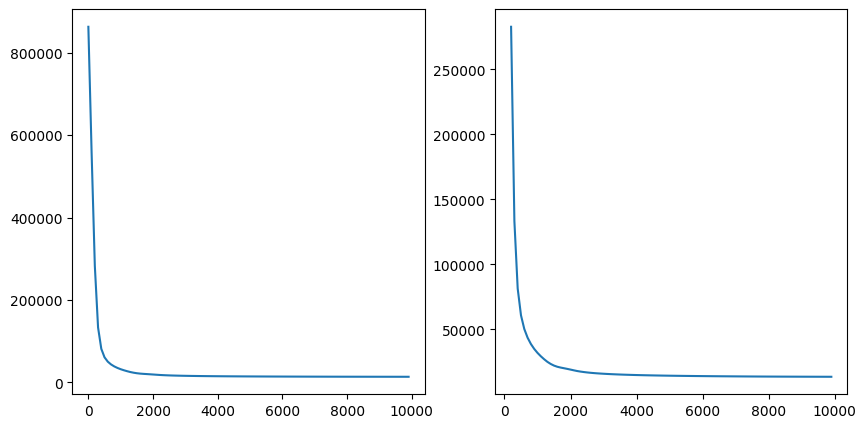

In [135]:
# plot of the loss
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1 = plt.plot(range(0, epochs, 100), losses)
ax2 = fig.add_subplot(1, 2, 2)
ax2 = plt.plot(range(0, epochs, 100)[2:], losses[2:])

## Inference

We can now use the model to make predictions. We can compute the accuracy of the model on the test set.

In [136]:
q = softmax(x_test @ W + b)

We have produced `q`, which gives the probability of each digit for each image in the test set. For example, `q[0]` gives the probability of each digit for the first image in the test set. 

In [137]:
q[0]

tensor([1.6422e-08, 7.7950e-15, 2.7636e-08, 3.2358e-03, 2.3474e-08, 4.6705e-06,
        5.8980e-12, 9.9659e-01, 4.9175e-06, 1.6421e-04])

We want to make a prediction by selecting the digit with the highest probability. We can use the `torch.argmax` function to extract the index of the maximum value in a tensor.

In [138]:
torch.argmax(q[0])

tensor(7)

Indeed, the true digit is `y_test[0]`.

In [139]:
torch.argmax(y_test[0])

tensor(7)

In [140]:
label_pred = torch.argmax(q, dim=1)
label_true = torch.argmax(y_test, dim=1)

In [141]:
p_correct_predictions = ( torch.sum(label_pred == label_true) / n_test_samples ).item()
print(f'Correct predictions: {p_correct_predictions*100:.4f}%')

Correct predictions: 92.5200%


Let's compare the accuracy of the model with a random guess.

In [142]:
p_random_predictions = ( torch.sum(torch.randint(0, n_classes, (n_test_samples,)) == label_true) / n_test_samples ).item()
print(f'Random predictions: {p_random_predictions*100:.4f}%')

Random predictions: 9.7100%


The improvement is significant.

## Plotting some misclassified images

In [143]:
# checking wrong predictions
wrong_predictions = (label_true != label_pred)
wrong_predictions

tensor([False, False, False,  ..., False, False, False])

In [144]:
x_test_wrong = x_test[wrong_predictions,:]
label_test_wrong = torch.argmax(y_test[wrong_predictions,:], dim=1)
label_pred_wrong = label_pred[wrong_predictions]

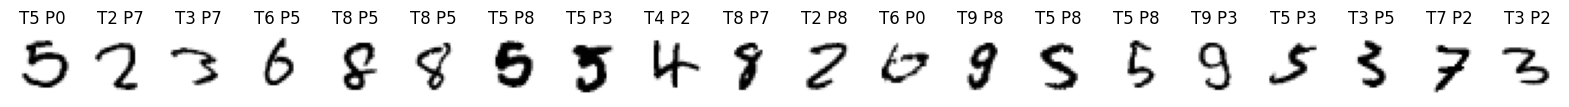

In [145]:
# plot of the wrong predictions
n_example = 20 
fig = plt.figure(figsize=(n_example, 1))
axs = []
offset = 20
for i in range(n_example):
  axs.append(fig.add_subplot(1, n_example, i+1))
  axs[i].imshow(x_test_wrong[offset+i,:].view(28,28), cmap='gray_r')
  axs[i].set_title(f'T{label_test_wrong[offset+i].item():.0f} P{label_pred_wrong[offset+i].item():.0f}')
  axs[i].axis('off')


### Question:
"Can we plot the weights of the model?"

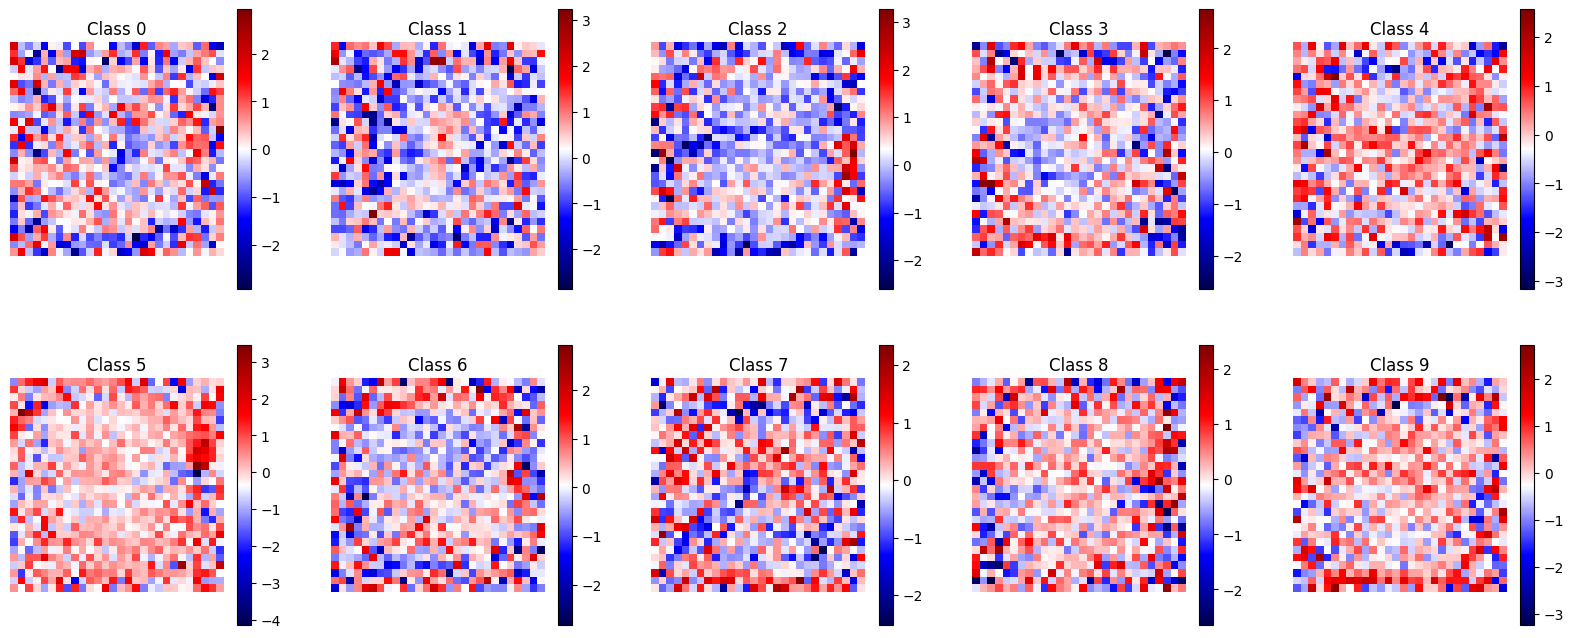

In [161]:
fig = plt.figure(figsize=(20, 8))
for i in range(10):
  ax = fig.add_subplot(2, 5, i+1)
  ax.imshow(W[:,i].view(28,28), cmap='seismic')
  ax.set_title(f'Class {i}')
  ax.axis('off')
  ax.set_aspect('equal')
  plt.colorbar(ax.imshow(W[:,i].view(28,28), cmap='seismic'))